Import Library

In [4]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import shutil

Persiapan Dataset

In [5]:
# Definisikan path dataset
dataset_dir = '/kaggle/input/garbage-classification/garbage_classification'

# Cek informasi dataset
classes = os.listdir(dataset_dir)
total_images = 0
class_counts = {}

for class_name in classes:
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count
        total_images += count
        print(f"Kelas {class_name}: {count} gambar")

print(f"Total kelas: {len(classes)}")
print(f"Total gambar: {total_images}")

Kelas metal: 769 gambar
Kelas white-glass: 775 gambar
Kelas biological: 985 gambar
Kelas paper: 1050 gambar
Kelas brown-glass: 607 gambar
Kelas battery: 945 gambar
Kelas trash: 697 gambar
Kelas cardboard: 891 gambar
Kelas shoes: 1977 gambar
Kelas clothes: 5325 gambar
Kelas plastic: 865 gambar
Kelas green-glass: 629 gambar
Total kelas: 12
Total gambar: 15515


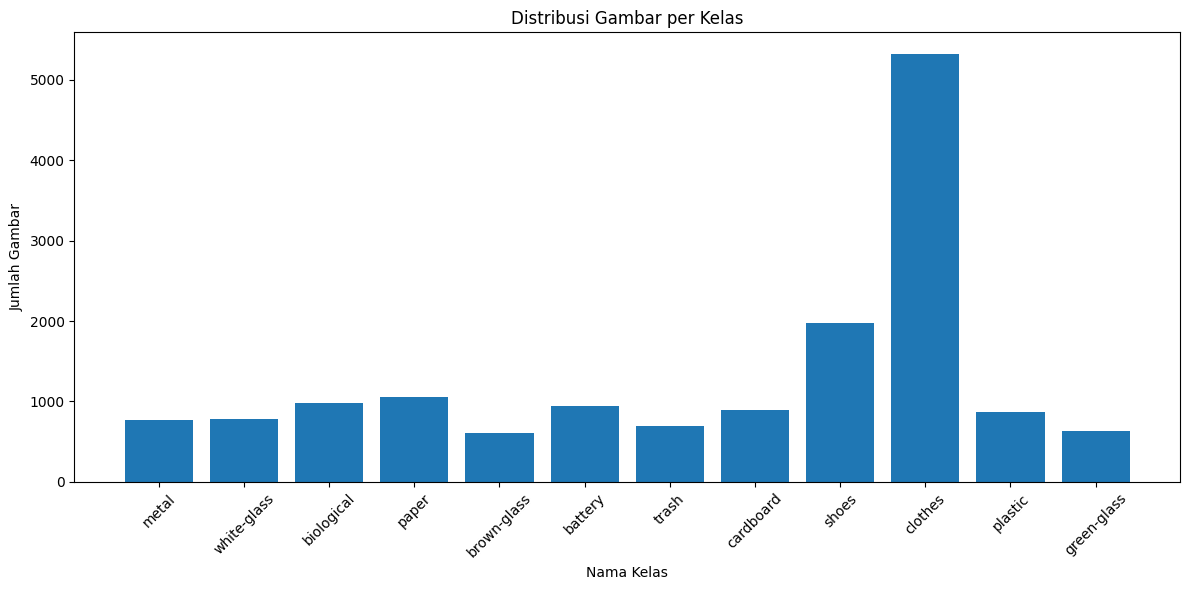

In [6]:
# Visualisasi distribusi kelas
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Distribusi Gambar per Kelas')
plt.xlabel('Nama Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Membuat dictionary untuk menyimpan path gambar per kelas
class_images = {}
for class_name in classes:
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [os.path.join(class_path, img) for img in os.listdir(class_path) 
                      if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_images[class_name] = image_files

# Membuat direktori untuk train, validation, dan test jika belum ada
base_dir = '/kaggle/working/garbage_classification_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Hapus direktori jika sudah ada untuk menghindari duplikasi
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

# Buat direktori baru
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)
    
    # Buat subfolder untuk setiap kelas
    for class_name in classes:
        if class_name != '.DS_Store' and os.path.isdir(os.path.join(dataset_dir, class_name)):
            os.makedirs(os.path.join(dir_path, class_name), exist_ok=True)

# Split data: 60% train, 20% validation, 20% test (Increased validation set)
for class_name, images in class_images.items():
    if class_name == '.DS_Store':  # Skip file sistem macOS jika ada
        continue
        
    # Split data untuk 3 set dengan validation set yang lebih besar
    train_imgs, test_val_imgs = train_test_split(images, test_size=0.4, random_state=42)
    val_imgs, test_imgs = train_test_split(test_val_imgs, test_size=0.5, random_state=42)
    
    # Salin file ke direktori yang sesuai
    for img_path in train_imgs:
        filename = os.path.basename(img_path)
        shutil.copy(img_path, os.path.join(train_dir, class_name, filename))
        
    for img_path in val_imgs:
        filename = os.path.basename(img_path)
        shutil.copy(img_path, os.path.join(val_dir, class_name, filename))
        
    for img_path in test_imgs:
        filename = os.path.basename(img_path)
        shutil.copy(img_path, os.path.join(test_dir, class_name, filename))

# Verifikasi struktur dan jumlah data
train_counts = {}
val_counts = {}
test_counts = {}

for class_name in classes:
    if os.path.isdir(os.path.join(dataset_dir, class_name)):
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        
        train_count = len(os.listdir(train_class_dir)) if os.path.exists(train_class_dir) else 0
        val_count = len(os.listdir(val_class_dir)) if os.path.exists(val_class_dir) else 0
        test_count = len(os.listdir(test_class_dir)) if os.path.exists(test_class_dir) else 0
        
        train_counts[class_name] = train_count
        val_counts[class_name] = val_count
        test_counts[class_name] = test_count
        
        print(f"Kelas {class_name}: {train_count} train, {val_count} validation, {test_count} test")

print(f"Total gambar train: {sum(train_counts.values())}")
print(f"Total gambar validation: {sum(val_counts.values())}")
print(f"Total gambar test: {sum(test_counts.values())}")

Kelas metal: 461 train, 154 validation, 154 test
Kelas white-glass: 465 train, 155 validation, 155 test
Kelas biological: 591 train, 197 validation, 197 test
Kelas paper: 630 train, 210 validation, 210 test
Kelas brown-glass: 364 train, 121 validation, 122 test
Kelas battery: 567 train, 189 validation, 189 test
Kelas trash: 418 train, 139 validation, 140 test
Kelas cardboard: 534 train, 178 validation, 179 test
Kelas shoes: 1186 train, 395 validation, 396 test
Kelas clothes: 3195 train, 1065 validation, 1065 test
Kelas plastic: 519 train, 173 validation, 173 test
Kelas green-glass: 377 train, 126 validation, 126 test
Total gambar train: 9307
Total gambar validation: 3102
Total gambar test: 3106


Pembagian Dataset & Augmentasi

In [8]:
# Konfigurasi - Reduced epochs to prevent overfitting
BATCH_SIZE = 32  # Increased batch size for better generalization
IMAGE_SIZE = 224  # Reduced input size to prevent overfitting
EPOCHS = 50  # Reduced epochs

# More conservative data augmentation to prevent overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Reduced from 40
    width_shift_range=0.1,  # Reduced from 0.2
    height_shift_range=0.1,  # Reduced from 0.2
    shear_range=0.1,  # Reduced from 0.2
    zoom_range=0.1,  # Reduced from 0.2
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],  # More conservative range
    validation_split=0.0  # We already have separate validation set
)

# Preprocessing sederhana untuk validation dan test data
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Siapkan generators dengan path yang sudah dibuat
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Mendapatkan jumlah kelas untuk model dan mapping kelas
classes = train_generator.class_indices
num_classes = len(classes)
print(f"Jumlah kelas: {num_classes}")
print("Kelas yang terdeteksi:", classes)

Found 9307 images belonging to 12 classes.
Found 3102 images belonging to 12 classes.
Found 3106 images belonging to 12 classes.
Jumlah kelas: 12
Kelas yang terdeteksi: {'battery': 0, 'biological': 1, 'brown-glass': 2, 'cardboard': 3, 'clothes': 4, 'green-glass': 5, 'metal': 6, 'paper': 7, 'plastic': 8, 'shoes': 9, 'trash': 10, 'white-glass': 11}


Membangun Model CNN

In [9]:
# Membuat base model dengan pre-trained weights
base_model = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

# More conservative fine-tuning approach
# Freeze more layers to prevent overfitting
for layer in base_model.layers:
    layer.trainable = False

# Only unfreeze the last few layers for minimal fine-tuning
fine_tune_at = -20  # Changed from -36 to freeze more layers
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Hitung jumlah layer yang trainable dan non-trainable
trainable_count = sum(1 for layer in base_model.layers if layer.trainable)
non_trainable_count = sum(1 for layer in base_model.layers if not layer.trainable)
print(f"Layer yang dapat dilatih: {trainable_count}")
print(f"Layer yang tidak dilatih: {non_trainable_count}")

# Simplified model architecture to prevent overfitting
model = Sequential([
    # Base model
    base_model,
    
    # Simpler head with more regularization
    GlobalAveragePooling2D(),
    
    # Reduced complexity with heavy regularization
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # Added L2 regularization
    BatchNormalization(),
    Dropout(0.6),  # Increased dropout
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Added L2 regularization
    BatchNormalization(),
    Dropout(0.5),  # High dropout
    
    # Output layer
    Dense(num_classes, activation='softmax')
])

# Lower learning rate to prevent overfitting
optimizer = Adam(learning_rate=1e-5)  # Much lower learning rate
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()

I0000 00:00:1750690032.883789      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750690032.884533      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Layer yang dapat dilatih: 20
Layer yang tidak dilatih: 112


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,422,004 (81.72 MB)

 Trainable params: 7,886,132 (30.08 MB)

 Non-trainable params: 13,535,872 (51.64 MB)

Callbacks

In [10]:
class Callback(Callback):
    def __init__(self, patience=5, min_delta=0.001):
        super().__init__()
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_val_loss = np.inf
        
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        
        train_acc = logs.get('accuracy', 0)
        val_acc = logs.get('val_accuracy', 0)
        train_loss = logs.get('loss', 0)
        val_loss = logs.get('val_loss', 0)
        
        # Calculate overfitting indicators
        acc_gap = train_acc - val_acc
        loss_gap = val_loss - train_loss
        
        print(f"\nEpoch {epoch+1}:")
        print(f"Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Accuracy Gap: {acc_gap*100:.2f}%, Loss Gap: {loss_gap:.4f}")
        
        # Warning if overfitting detected
        if acc_gap > 0.15 or loss_gap > 0.5:
            print("Overfitting detected!")
        
        # Early stopping based on validation loss improvement
        if val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nStopping training due to no improvement in validation loss for {self.patience} epochs")
                self.model.stop_training = True

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,  
    restore_best_weights=True,
    verbose=1,
    mode='min',
    min_delta=0.001
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, 
    patience=5, 
    min_lr=1e-8,
    verbose=1,
    cooldown=2
)

callback = Callback(patience=8)

callbacks_list = [early_stopping, model_checkpoint, reduce_lr, callback]

Melatih Model

In [11]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks_list,
    verbose=1
)

# Evaluasi model pada test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1750690050.451669     147 service.cc:148] XLA service 0x7c4f78001c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750690050.457372     147 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750690050.457394     147 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750690052.067104     147 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1750690061.131972     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750690061.274049     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1750690066.657239     147 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most onc

 64/291 ━━━━━━━━━━━━━━━━━━━━ 1:24 373ms/step - accuracy: 0.0852 - loss: 10.0642

E0000 00:00:1750690097.211627     145 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750690097.349865     145 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.1174 - loss: 9.7652
Epoch 1: val_accuracy improved from -inf to 0.53482, saving model to best_model.keras

Epoch 1:
Train Acc: 16.42%, Val Acc: 53.48%
Train Loss: 9.4199, Val Loss: 7.8919
Accuracy Gap: -37.06%, Loss Gap: -1.5280
291/291 ━━━━━━━━━━━━━━━━━━━━ 176s 510ms/step - accuracy: 0.1175 - loss: 9.7641 - val_accuracy: 0.5348 - val_loss: 7.8919 - learning_rate: 1.0000e-05
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.3097 - loss: 8.6344
Epoch 2: val_accuracy improved from 0.53482 to 0.67473, saving model to best_model.keras

Epoch 2:
Train Acc: 34.55%, Val Acc: 67.47%
Train Loss: 8.4436, Val Loss: 7.3291
Accuracy Gap: -32.92%, Loss Gap: -1.1144
291/291 ━━━━━━━━━━━━━━━━━━━━ 129s 442ms/step - accuracy: 0.3098 - loss: 8.6338 - val_accuracy: 0.6747 - val_loss: 7.3291 - learning_rate: 1.0000e-05
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.4413 - loss: 8.0578
Epoch 3: val_accuracy improv

Visualisasi Hasil Training

In [16]:
def plot_training_analysis(history, test_acc): 

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy'] 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    # Calculate gaps for overfitting analysis
    acc_gaps = [train_acc - val_acc for train_acc, val_acc in zip(acc, val_acc)]
    loss_gaps = [val_loss - train_loss for train_loss, val_loss in zip(loss, val_loss)]

    plt.figure(figsize=(18, 12))

    # Plot accuracy
    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy', linewidth=2)
    plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # Plot loss
    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, loss, 'bo-', label='Training Loss', linewidth=2)
    plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss', linewidth=2)
    plt.title('Model Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # Plot accuracy gap (overfitting indicator)
    plt.subplot(2, 3, 3)
    plt.plot(epochs_range, acc_gaps, 'go-', label='Accuracy Gap', linewidth=2)
    plt.axhline(y=0.1, color='orange', linestyle='--', label='Warning Threshold')
    plt.axhline(y=0.15, color='red', linestyle='--', label='Overfitting Threshold')
    plt.title('Accuracy Gap Analysis', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Training - Validation Accuracy')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # Plot loss gap (overfitting indicator)
    plt.subplot(2, 3, 4)
    plt.plot(epochs_range, loss_gaps, 'mo-', label='Loss Gap', linewidth=2)
    plt.axhline(y=0.3, color='orange', linestyle='--', label='Warning Threshold')
    plt.axhline(y=0.5, color='red', linestyle='--', label='Overfitting Threshold')
    plt.title('Loss Gap Analysis', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Validation - Training Loss')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # Final performance comparison
    final_train_acc = acc[-1]
    final_val_acc = val_acc[-1]
    test_acc_value = test_acc # <--- Now 'test_acc' comes from the function argument

    plt.subplot(2, 3, 5)
    labels = ['Training', 'Validation', 'Testing']
    values = [final_train_acc*100, final_val_acc*100, test_acc_value*100]
    colors = ['blue', 'orange', 'green']

    bars = plt.bar(labels, values, color=colors, alpha=0.7)
    plt.ylabel('Accuracy (%)')
    plt.title('Final Performance Comparison', fontsize=14, fontweight='bold')
    plt.ylim(0, 100)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')

    # Calculate and display generalization metrics
    generalization_gap = final_train_acc - final_val_acc
    test_generalization = final_val_acc - test_acc_value

    plt.subplot(2, 3, 6)
    gap_labels = ['Train-Val Gap', 'Val-Test Gap']
    gap_values = [generalization_gap*100, test_generalization*100]
    # Adjusting color logic for gaps: red for larger gaps, green for smaller
    gap_colors = ['red' if abs(gap) > 5 else 'orange' if abs(gap) > 2 else 'green' for gap in gap_values]

    bars = plt.bar(gap_labels, gap_values, color=gap_colors, alpha=0.7)
    plt.ylabel('Accuracy Gap (%)')
    plt.title('Generalization Analysis', fontsize=14, fontweight='bold')
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.axhline(y=5, color='orange', linestyle='--', alpha=0.5, label='Warning (Positive Gap)')
    plt.axhline(y=-5, color='orange', linestyle='--', alpha=0.5, label='Warning (Negative Gap)')
    plt.legend() # Add legend for gap thresholds

    # Add value labels
    for bar, value in zip(bars, gap_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5 if value >= 0 else bar.get_height() - 0.5,
                 f'{value:.2f}%', ha='center', va='bottom' if value >= 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

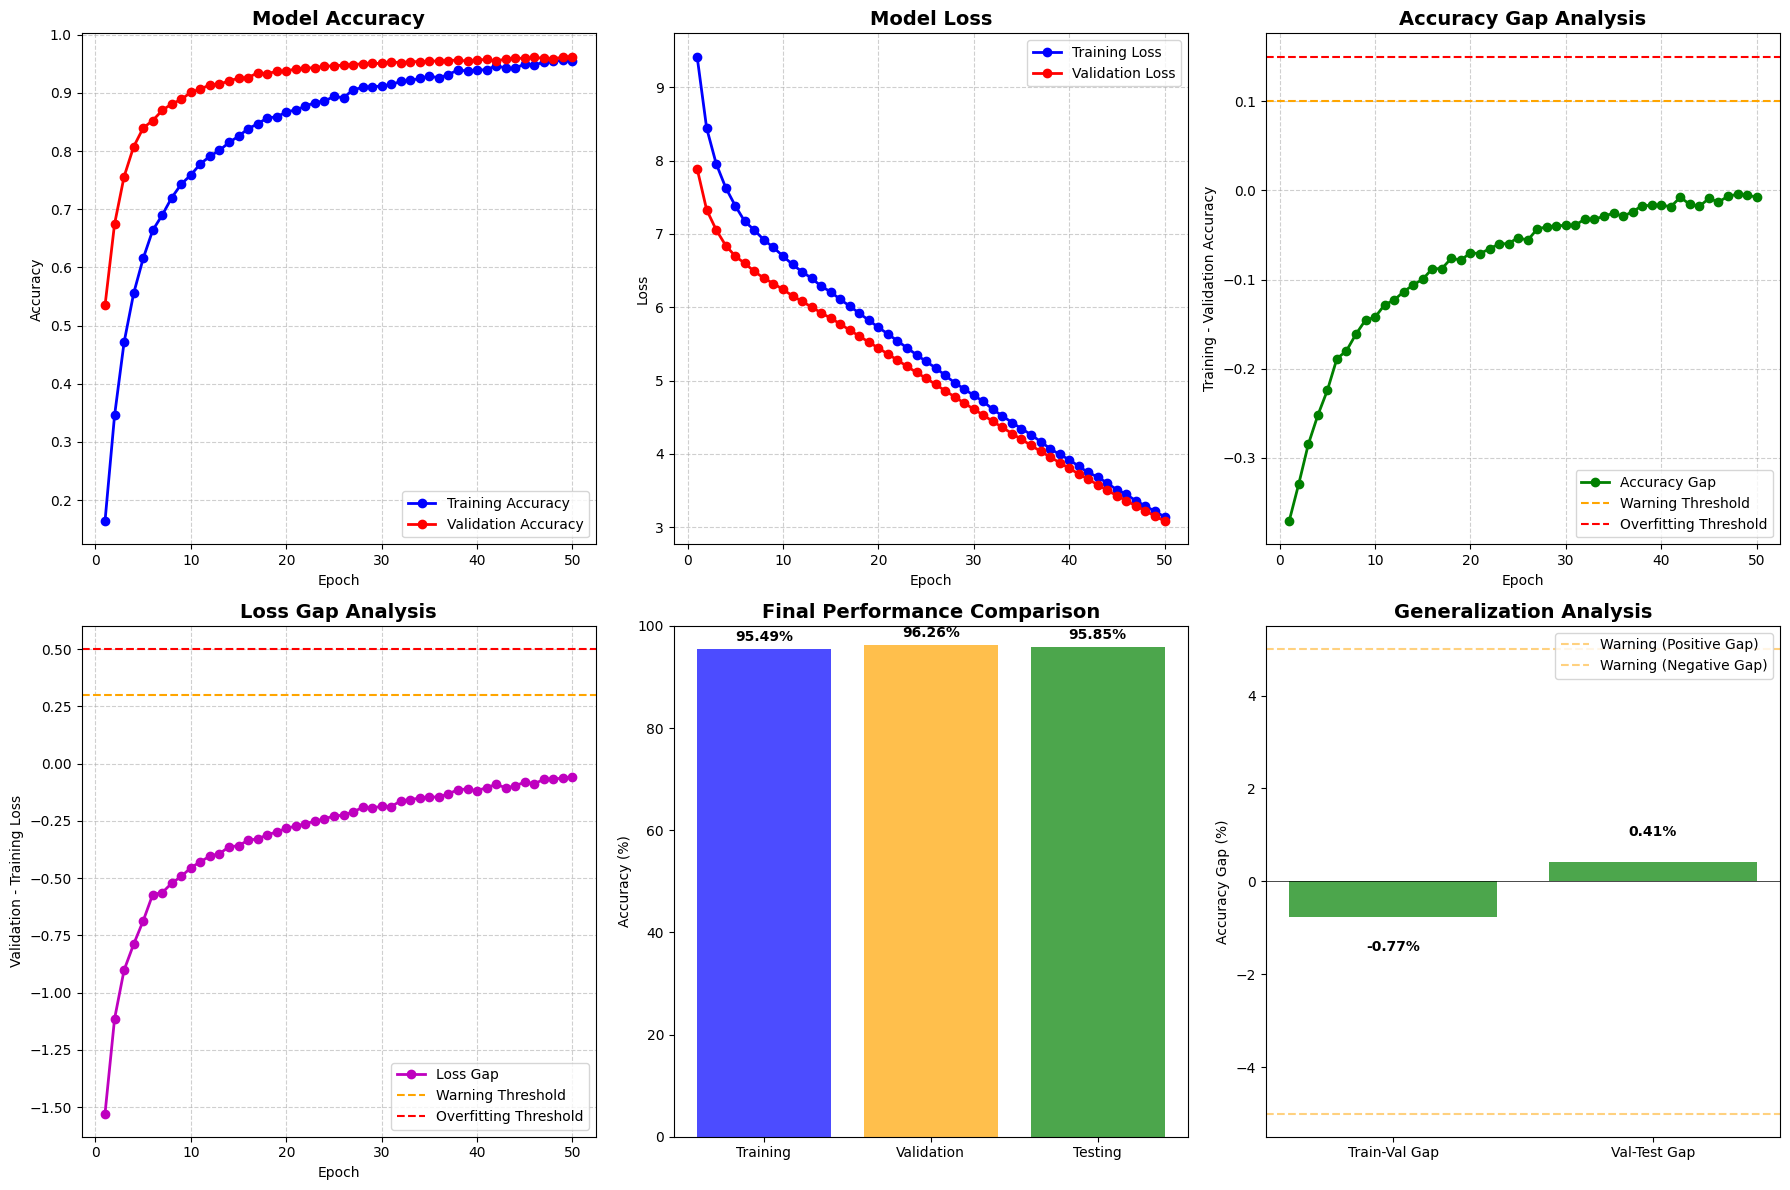

In [17]:
plot_training_analysis(history, test_acc)